# Where to buy in DC, to make a profit in a year.

In this project, we look at the sale prices for the different zipcodes in DC, and try to answer:

    What are the hottest zip codes in DC?
    
For this project, a hot zip code is one where we will make a profit if we buy a house, and sell it after one year.

In this project we will perform a time series analysis on the DC sales data, find the best model that fits the data, and use that model to predict what will be the selling price one year into the future.

## Loading the data

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
# Load the data
from get_data import *
dc_df_T = get_the_data()
zipcodes = list(dc_df_T.columns)

# Initial inspection
dc_df_T.head()

,20002,20009,20011,20019,20001,20020,20008,20003,20032,20016,20010,20007,20024,20017,20018,20037,20015,20012
date,,,,,,,,,,,,,,,,,,
1996-04-01,94300.0,178800.0,118900.0,91300.0,92000.0,104500.0,450100.0,130000.0,85700.0,362000.0,110500.0,358100.0,209800.0,121700.0,123000.0,277800.0,312400.0,185000.0
1996-05-01,94000.0,179200.0,118500.0,91000.0,92600.0,103800.0,448200.0,130100.0,85500.0,361200.0,111200.0,356000.0,208200.0,121400.0,122400.0,275800.0,311000.0,184900.0
1996-06-01,93700.0,179600.0,118200.0,90600.0,93200.0,103000.0,446300.0,130200.0,85400.0,360300.0,112000.0,353900.0,206600.0,121200.0,121800.0,273700.0,309800.0,184700.0
1996-07-01,93600.0,180000.0,117800.0,90400.0,93900.0,102200.0,444500.0,130400.0,85200.0,359400.0,112900.0,351700.0,205000.0,121000.0,121200.0,271600.0,308700.0,184400.0
1996-08-01,93400.0,180300.0,117600.0,90100.0,94600.0,101400.0,442900.0,130600.0,85000.0,358500.0,113800.0,349600.0,203300.0,120900.0,120700.0,269500.0,307900.0,184100.0


In [3]:
# import matplotlib and set some parametrs
pd.set_option('display.max_columns', 500)
import matplotlib 

import matplotlib.pyplot as plt
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
plt.rcParams['figure.figsize'] = 12, 6

In [23]:
# check for NA
dc_df_T.isna().sum()

20002    0
20009    0
20011    0
20019    0
20001    0
20020    0
20008    0
20003    0
20032    0
20016    0
20010    0
20007    0
20024    0
20017    0
20018    0
20037    0
20015    0
20012    0
dtype: int64

Data looks good, no null values present. 

# Can we predict housing prices?

In [4]:
# Import the functions created to analyze the data
from all_the_functions import *

Let's start by analyzing one  zip code: 20020

Text(0, 0.5, 'Seasonal')

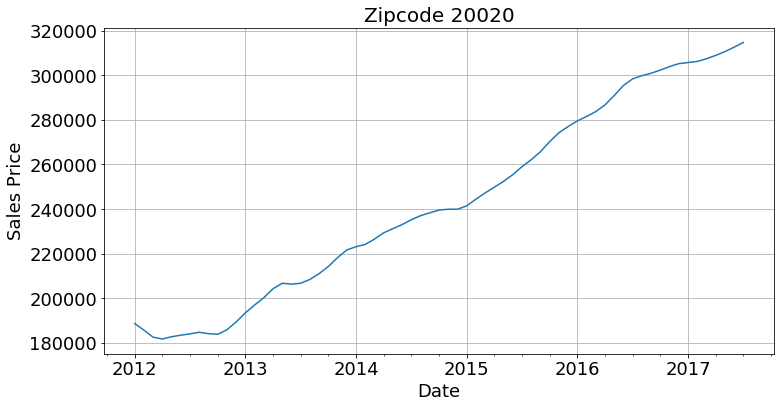

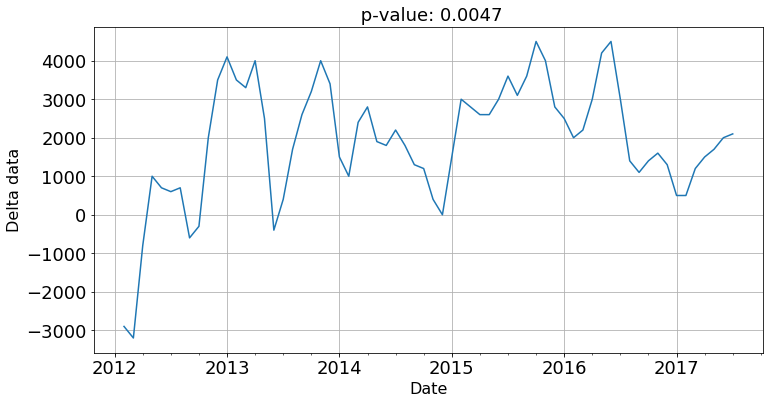

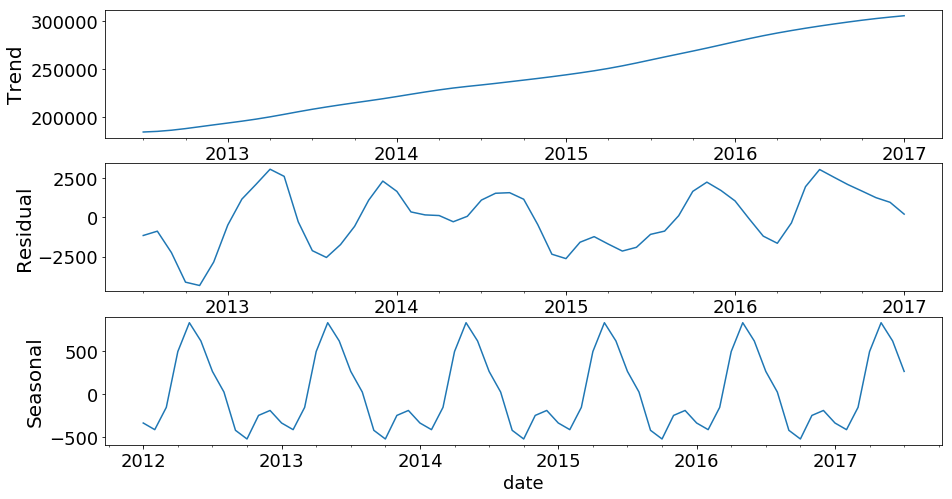

In [41]:
data = dc_df_T.loc['2012-01-01':'2017-07-1'][20020]

# Plot the data
fig = plt.figure(figsize=(12,6))
data.plot()
plt.grid(True)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Sales Price',fontsize=18)
plt.title('Zipcode 20020', fontsize=20)

#Transforma the data, shift it by 1 
data_shift = data.shift(1)

# Plot the difference between the data and the data_shift, the p-value from 
# an Augmented Dickey Fuler Test is shown on the plot
Plot_Compare(data, data_shift)

# Finally, let's look at the decomposition of the data
decomposition = sm.tsa.seasonal_decompose(data, model='additive')
# fig = plt.figure(figsize=(12,6))
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
decomposition.trend.plot(ax=ax1)
plt.xlabel('Date',fontsize=18)
decomposition.resid.plot(ax=ax2)
decomposition.seasonal.plot(ax=ax3)
ax1.set_ylabel('Trend',fontsize=20)
ax2.set_ylabel('Residual',fontsize=20)
ax3.set_ylabel('Seasonal',fontsize=20)



From the last plot above, there is a small seasonal component, so we will use
a SARIMA model to fit the timeseries

Now, let's look at all the zipcodes. For each one, we will follow these steps:

     - Get the series data
     
     - Split the data into train and test datasets based on a time cut = 2017-07
     
     - Run the Trend_elimination function. This function will test different transformations,
     apply an Augmented Dickey-Fuller test to test for a stationary data set. The function
     will return the dataset with the lowest p-value
     
     - Use the stationary data to find the p and q parameters. The p parameters are extracted
     from an ACF test, and the q parameters from a PACF test. In both cases we select the 
     elements outside a 2-sigma window
     
     - Run seveal SARIMA models using the p and q parameters from the previous step. 
     Fit each model on the train data set, calculate the AIC score and return the model 
     with the lowest AIC score
    

In [6]:
results = []
train_data = []
test_data =[]
pdq_params = []
seasonal_pdq_params = []

for zipcode in zipcodes:
    #define the start of the time series
    time_start = '2012'
    # define time_cut, everything before will be train data, everything after 
    # will be test data
    time_cut = '2017-07'
    
    y = dc_df_T[zipcode].resample('MS').mean()
    y_train = y[time_start:time_cut]

    y_test = y[time_cut:]
    y_test = y_test[1:]
    
    # make it stationary
    name, pvalue, ybest_data = Trend_elimination(y_train)    
    print("{} The best data is the '{}' data set \npvalue:{}".format(zipcode, name, pvalue))
    
    # Get the Parameters on the difference between y and ybest
    y_diff = y_train - ybest_data
    y_diff.dropna(inplace=True)
    # Get the p and q parameters
    p_params = Get_p_params(y_diff)
    q_params = Get_q_params(y_diff)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        # Test several SARIMA models on the train data and return the 
        # model with the lowest AIC score
        model, best_order, best_seasonal_order = Get_Best_Model(y_train,
                                                        p_params,
                                                        q_params)
    
        result = model.fit()
        results.append(result)
        train_data.append(y_train)
        test_data.append(y_test)
        pdq_params.append(best_order)
        seasonal_pdq_params.append(best_seasonal_order)

20002 The best data is the 'rolling_mean_data' data set 
pvalue:0.03039488062411294
................................................................-
................................................................-
................................................................-
................................................................-
................................................................-
....20009 The best data is the 'diff_data_12' data set 
pvalue:1.6828979089714616e-05
................................................................-
................................................................-
................................................................-
................................................................-
................................................................-
....20011 The best data is the 'diff_data_12' data set 
pvalue:0.011673803660303456
................................................................-
....................

In [7]:
# Save is as a pickle file, so we don't have to retest the models
import pickle
PIK = "zillow_fits_zeroq.pkl"


with open(PIK, "wb") as f:
    for res in results:
#         print(res)
        pickle.dump(res, f)
    for pdq in pdq_params:
        pickle.dump(pdq, f)
    for spdq in seasonal_pdq_params:
        pickle.dump(spdq,f)

Let's look at the profits predicted by each model.

In [8]:
from sklearn import metrics

profit = []
percent = []
for model in results:
    pred = model.get_prediction(start=pd.to_datetime('2018-04'),
                              end=pd.to_datetime('2019-04'),
                             dynamic=True)
    profit.append(pred.predicted_mean[-1] - pred.predicted_mean[0])
    percent.append(pred.predicted_mean[-1]/pred.predicted_mean[0]-1)
    
root_mean = []
r2 = []
for model in results:
    pred = model.get_prediction(start=pd.to_datetime('2017-08-01'),
                              end=pd.to_datetime('2018-04-01'),
                             dynamic=True)
    root_mean.append(np.sqrt(metrics.mean_squared_error(test_data[0], pred.predicted_mean)))
    r2.append(metrics.r2_score(test_data[0], pred.predicted_mean))

In [9]:
df_profits = pd.DataFrame({'zipcode': zipcodes, 'profit': profit, 'percent': percent, 'rmse': root_mean, 'r2': r2})
df_profits

,zipcode,profit,percent,rmse,r2
0,20002,51408.251543,0.073114,8454.091066,-0.384328
1,20009,62954.439866,0.060516,353695.129301,-2422.055171
2,20011,30385.687270,0.050430,84295.741550,-136.631048
3,20019,30968.877871,0.097087,371672.763985,-2674.633464
4,20001,65181.625588,0.081634,103728.175469,-207.400436
5,20020,23332.093335,0.069855,352629.205133,-2407.472549
6,20008,195346.095964,0.135045,780471.945854,-11797.308238
7,20003,37673.303567,0.045162,142719.809826,-393.524212
8,20032,18077.310001,0.053221,358484.456818,-2488.119831
9,20016,87643.586569,0.071772,519307.339145,-5222.409385


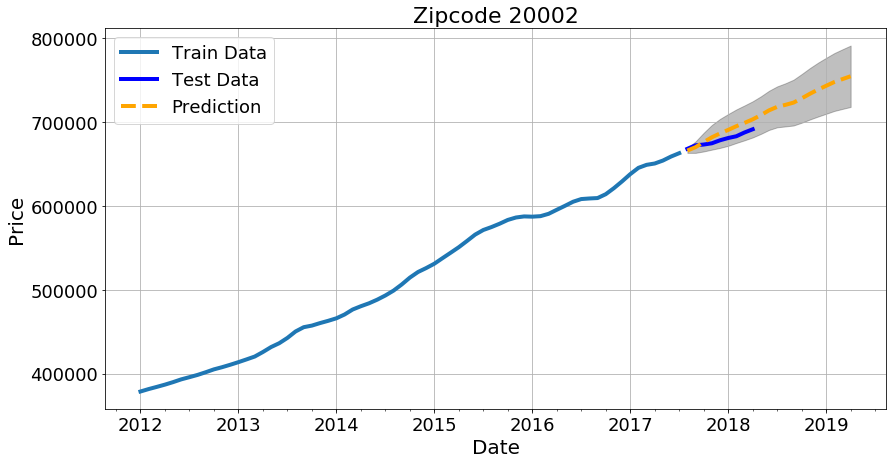

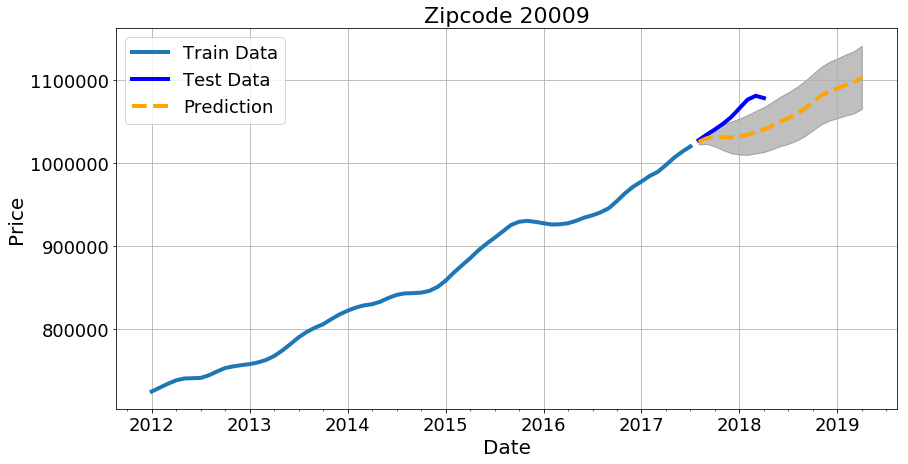

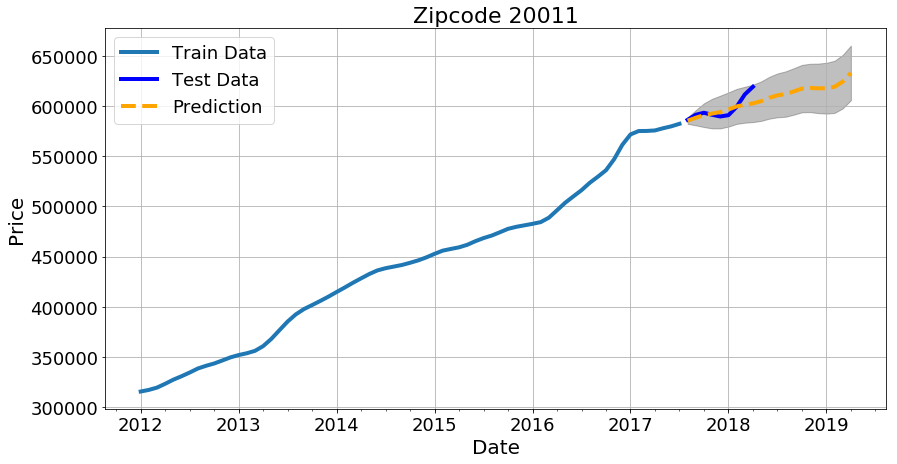

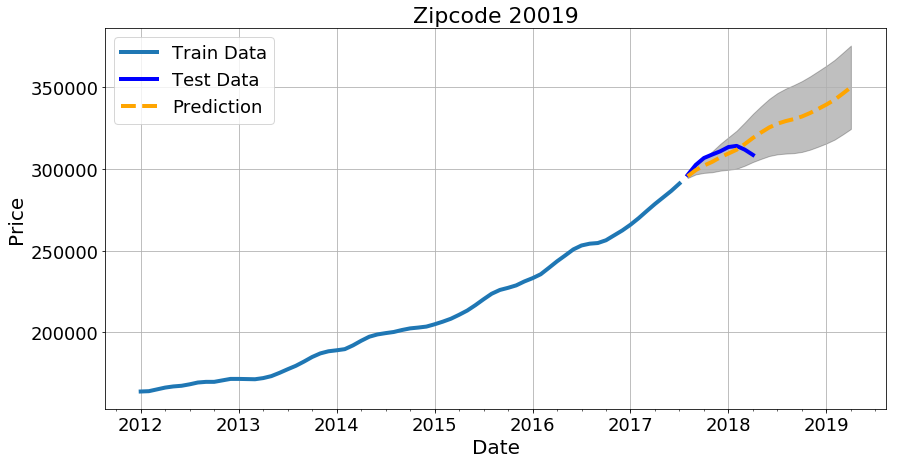

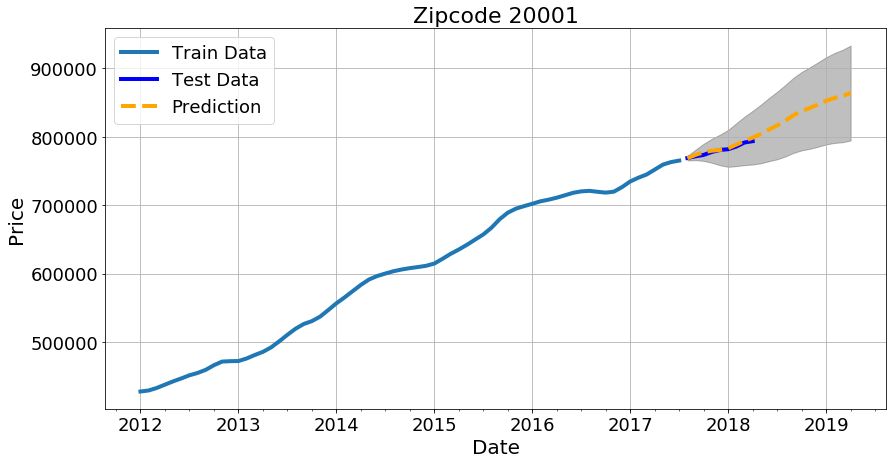

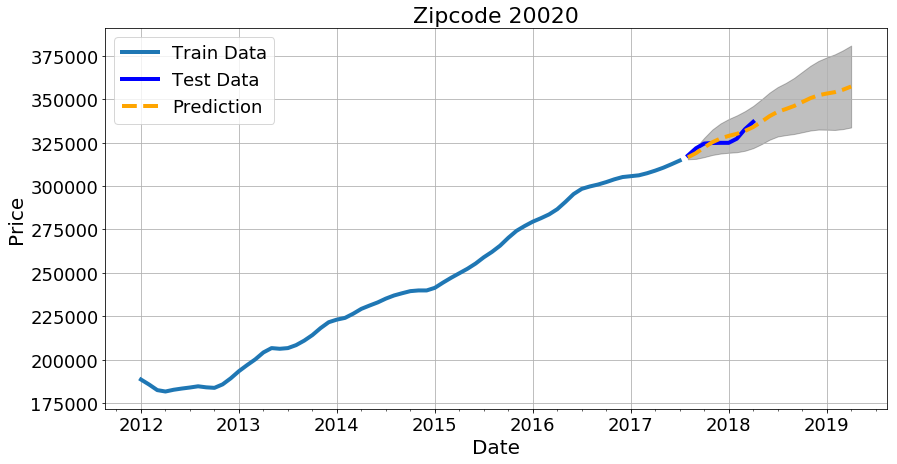

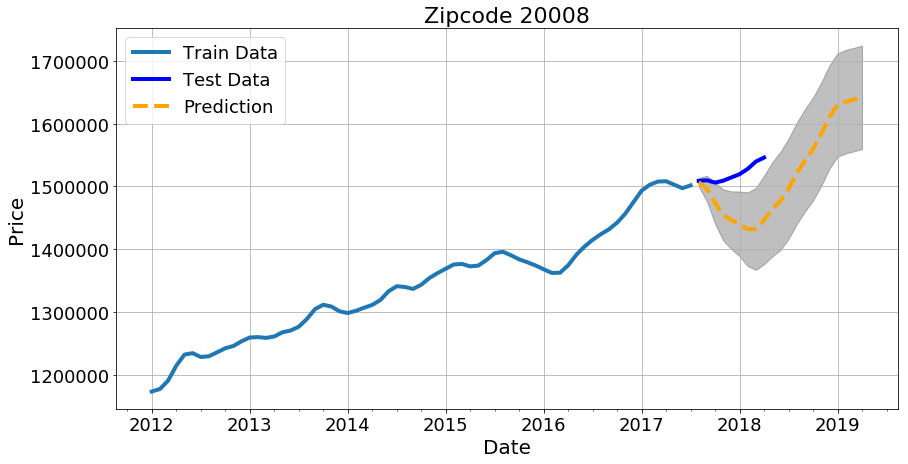

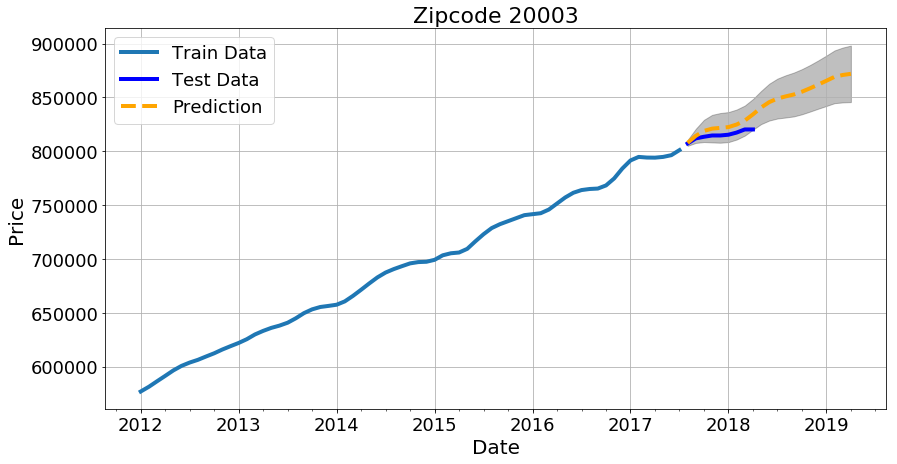

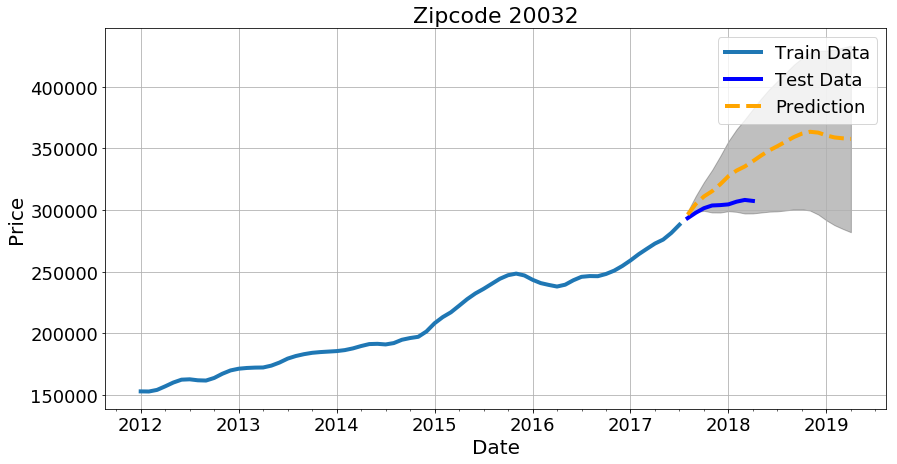

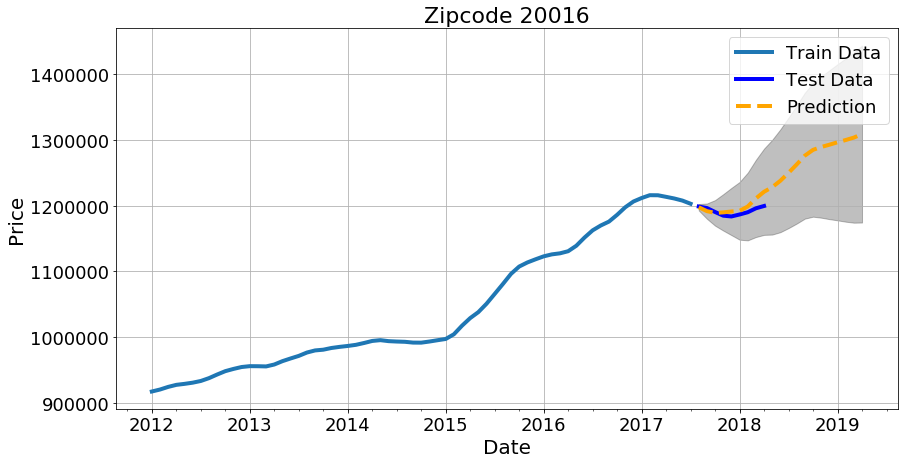

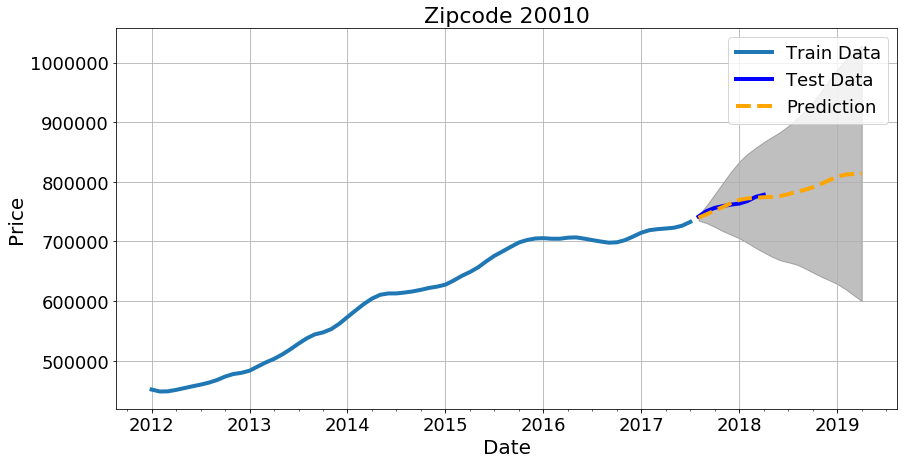

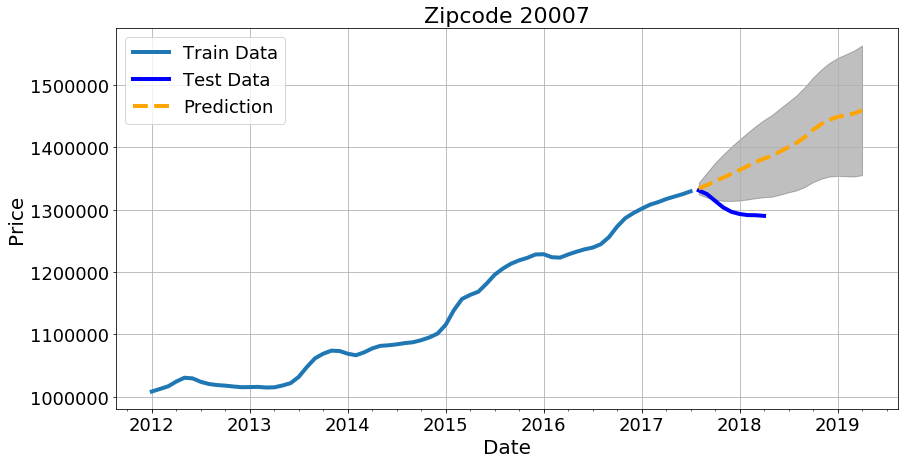

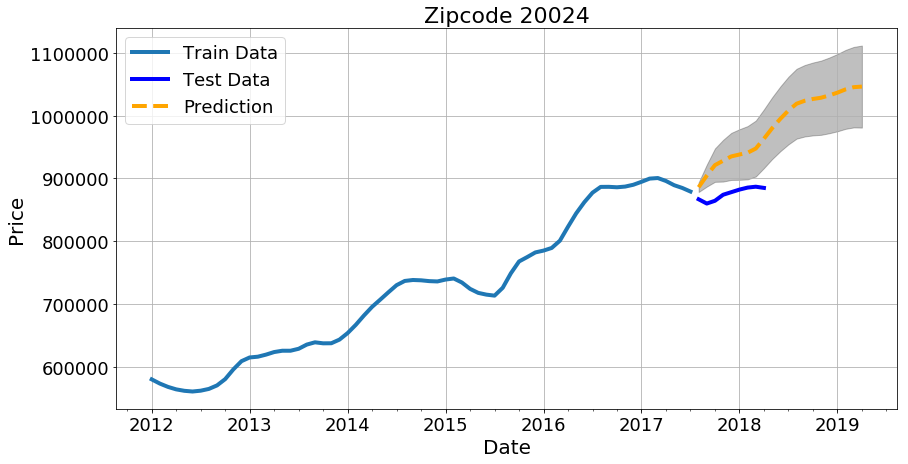

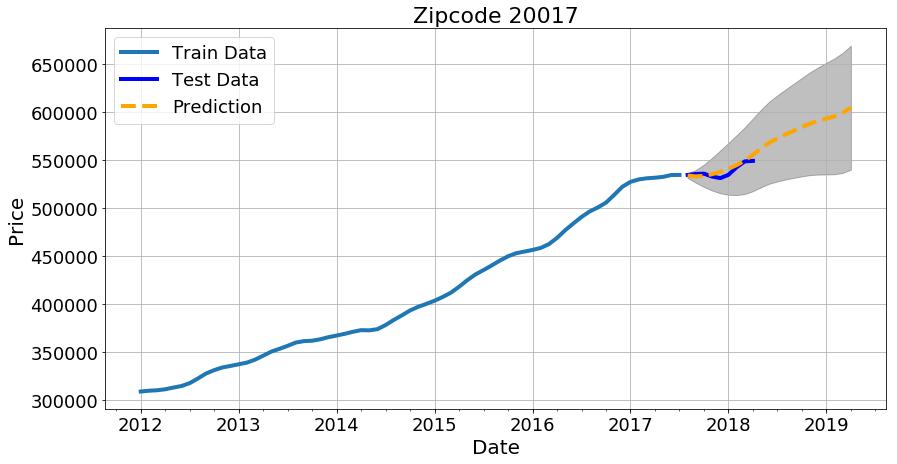

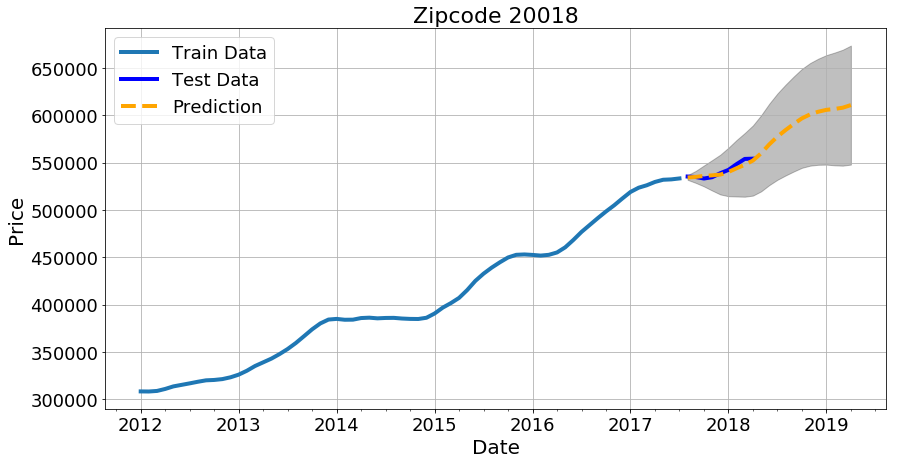

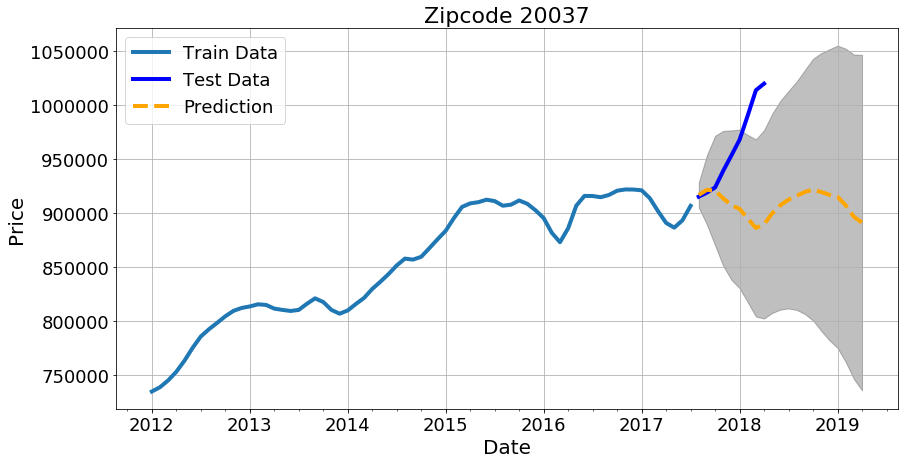

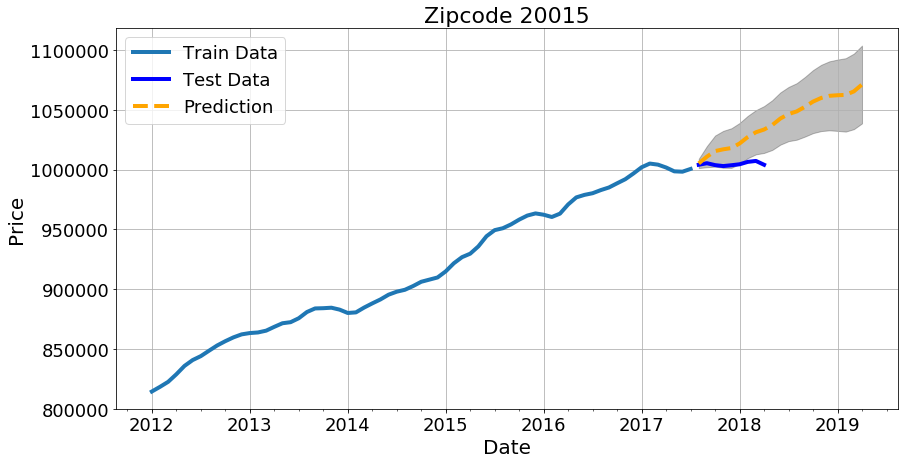

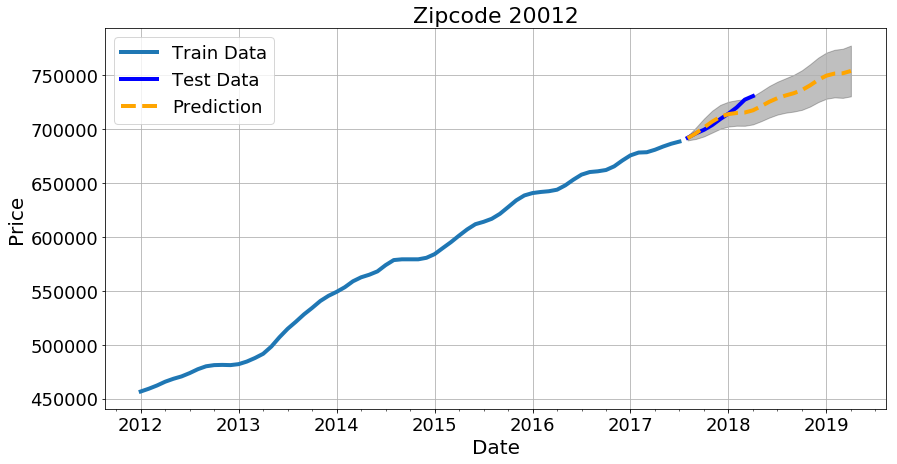

In [43]:
# for each zipcode, plot the sales train data, the sales 
# test data, and the prediction from the time cut up to 2019-04
time_cut = '2017-07'
for i, zcode in enumerate(zipcodes):
    Make_PredictionPlot(results[i], train_data[i], test_data[i], 
                        zcode, time_cut, print_test=True)
#     plt.savefig('Figures_Training_Models/zcode_{}.png'.format(zcode))

## Let's get the best models

From the plots above, we can see we are able to reproduce the test data for
some of the zip codes,  (for example 20002), but not all of them, (see zipcode 20008)

Let's only look at the zipcodes where we are able to predict the test data. We will compare the Root Mean Square and the R2 between the predicted and the test data.

In [11]:
from sklearn import metrics

root_mean = []
r2 = []
for i,model in enumerate(results):
    pred = model.get_prediction(start=(pd.to_datetime(time_cut) + pd.DateOffset(months=1)),
                              end=pd.to_datetime('2018-04-01'),
                             dynamic=True)
    root_mean.append(np.sqrt(metrics.mean_squared_error(test_data[i], pred.predicted_mean)))
    r2.append(metrics.r2_score(test_data[i], pred.predicted_mean))


(-10, 2)

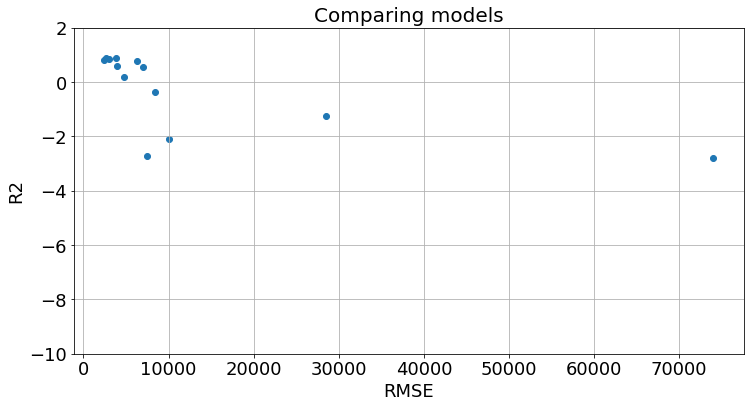

In [45]:
fig = plt.figure(figsize=(12,6))
plt.scatter(root_mean, r2)
plt.grid(True)
plt.title('Comparing models', fontsize = 20)
plt.xlabel('RMSE',fontsize=18)
plt.ylabel('R2',fontsize=18)
plt.ylim(-10,2)

From the plot above, let's select the zipcodes with the lowest RMS and the highest R2 values.

On those zipcodes, we will take the SARIMA parameters that best fitted the data, and create a new model, but not on the whole data set.

In [14]:
final_zipcodes = []
final_results = []
final_train_data = []
final_test_data =[]
final_pdq_params = []
final_seasonal_pdq_params = []
time_start = '2012'
time_cut = '2018-04'


for i,model in enumerate(results):
    if(r2[i]>-2 and root_mean[i]<10000):  

        zipcode = zipcodes[i]
        final_zipcodes.append(zipcode)
        y = dc_df_T[zipcode].resample('MS').mean()
        y_train = y[time_start:time_cut]

        y_test = y[time_cut:]
        y_test = y_test[1:]
    

        p_params = pdq_params[i]
        q_params = seasonal_pdq_params[i]
    
        # Fit the MODEL with the best parameters
        print(q_params)
        model = sm.tsa.statespace.SARIMAX(y_train,
                                        order=p_params,
                                        seasonal_order=q_params,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        result = model.fit()
        final_results.append(result)
        final_train_data.append(y_train)
        final_test_data.append(y_test)
        final_pdq_params.append(best_order)
        final_seasonal_pdq_params.append(best_seasonal_order)

(2, 1, 0, 12)
(2, 1, 0, 12)
(2, 1, 1, 12)
(2, 1, 0, 12)
(2, 1, 0, 12)
(2, 1, 0, 12)
(2, 1, 0, 12)
(2, 1, 0, 12)
(2, 1, 0, 12)


Let's make the plots and see at future predictions

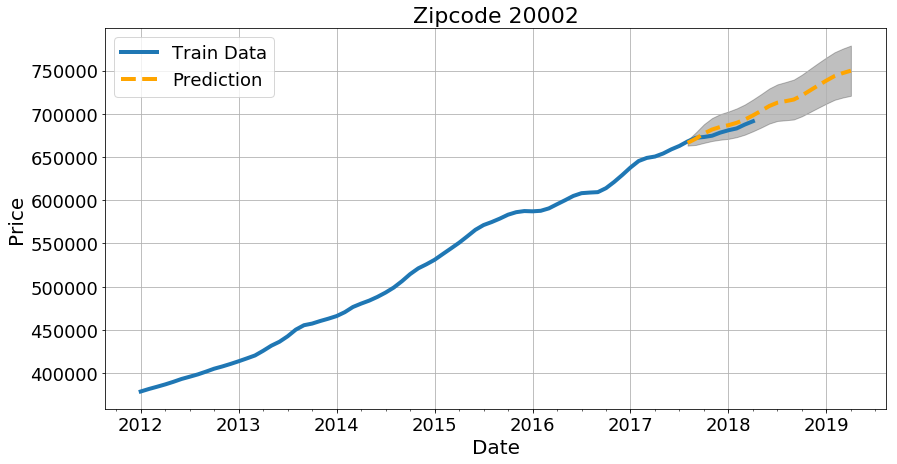

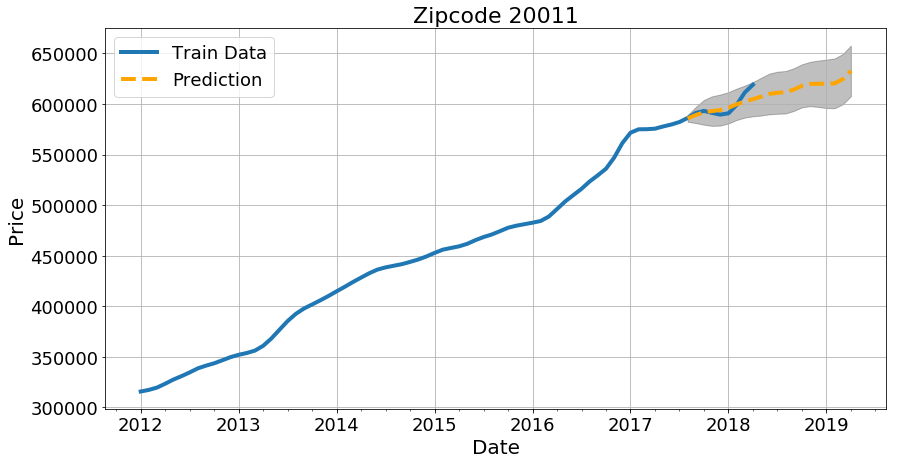

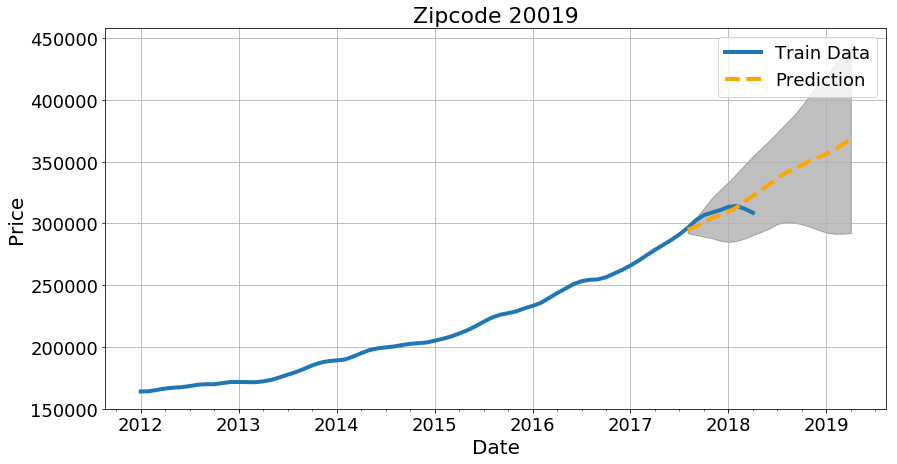

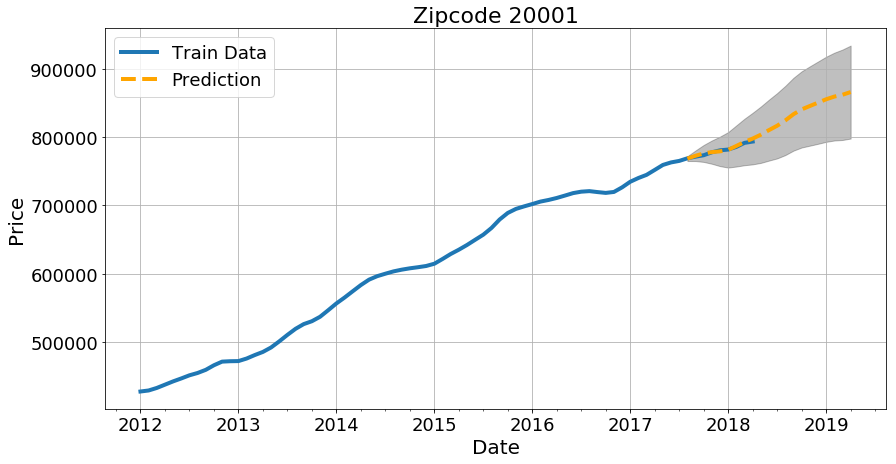

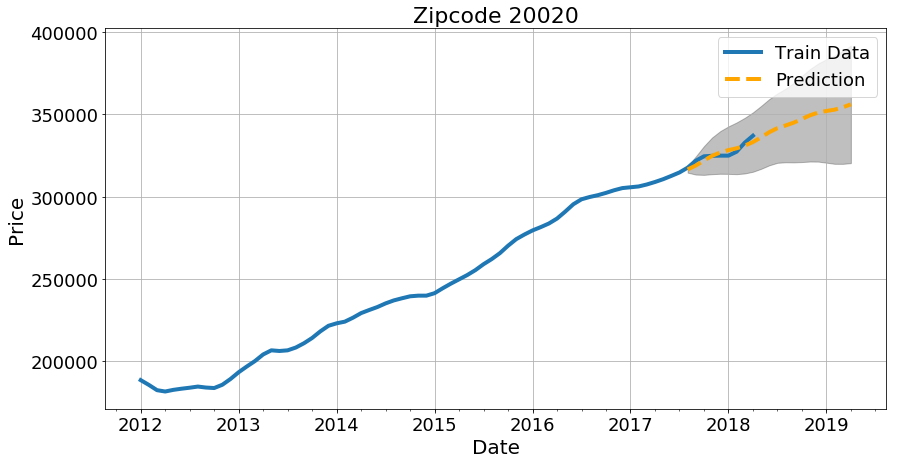

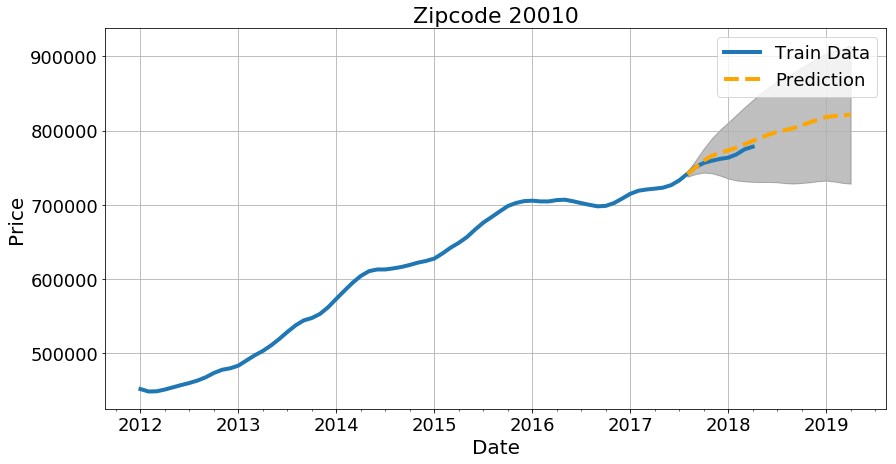

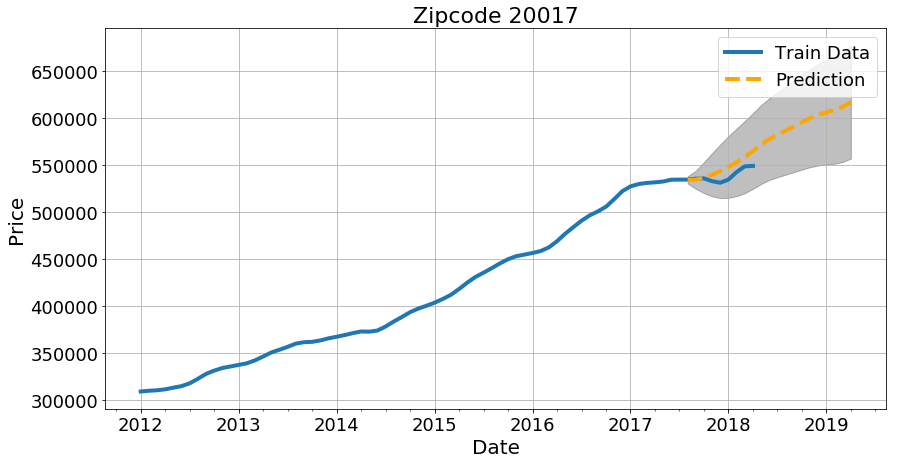

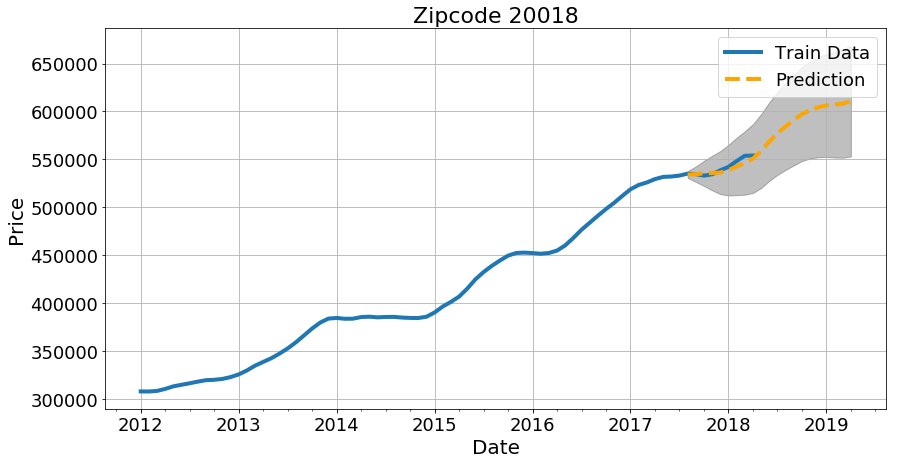

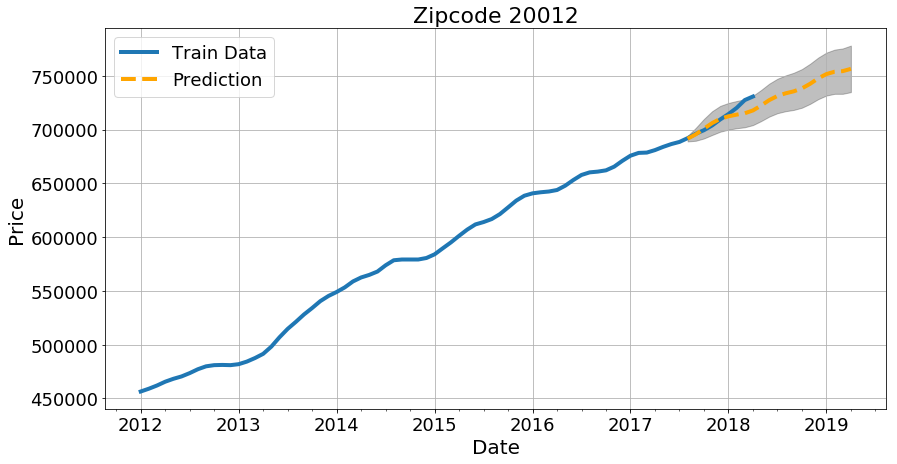

In [47]:
for i, val in enumerate(final_zipcodes):

    Make_PredictionPlot(final_results[i], final_train_data[i], 
                        final_test_data[i], val,time_cut, print_test=False)
    plt.savefig('Figures_Final_Models/zcode_{}.png'.format(val))

# Finally let's pick the best neighborhoods.

Let's look at the predictions for each zipcode, and see what would be the profit
if buying a house in 2018-04 and selilng it a year later.
We also calculate what would be the error on those numbers.

In [16]:
profit = []
percent = []
profit_error = []

for model in final_results:
    pred = model.get_prediction(start=pd.to_datetime('2018-04'),
                              end=pd.to_datetime('2019-04'),
                             dynamic=True)
    pred_ci = pred.conf_int()
    
    error_A = (pred_ci.iloc[0,1] - pred_ci.iloc[0,0])/2
    error_B = (pred_ci.iloc[-1,1] - pred_ci.iloc[-1,0])/2
    error_profit = np.sqrt(error_A**2 + error_B**2)
    
    profit.append(pred.predicted_mean[-1] - pred.predicted_mean[0])
    percent.append(pred.predicted_mean[-1]/pred.predicted_mean[0]-1)
    profit_error.append(error_profit)

In [17]:
df_pred = pd.DataFrame({'zipcode':final_zipcodes,'profit':profit, 'percent': percent, "profit_error": profit_error}) 

In [18]:
df_pred['worst_case'] = df_pred['profit'] - df_pred['profit_error']
df_pred['best_case'] = df_pred['profit'] + df_pred['profit_error']


In [19]:
df_pred.sort_values(by='worst_case', ascending=False)

,zipcode,profit,percent,profit_error,worst_case,best_case
0,20002,51335.432634,0.074022,22330.807723,29004.624911,73666.240357
3,20001,69517.800020,0.087255,50776.886673,18740.913347,120294.686693
8,20012,35354.881267,0.048185,16844.462012,18510.419255,52199.343279
7,20018,60362.872894,0.107839,45445.046787,14917.826107,105807.919681
4,20020,24982.809239,0.074052,22413.572001,2569.237238,47396.381240
6,20017,48220.844591,0.087034,46996.790009,1224.054582,95217.634600
1,20011,12696.062846,0.020438,21270.718382,-8574.655537,33966.781228
2,20019,24830.816896,0.080303,39606.608263,-14775.791368,64437.425159
5,20010,43408.601852,0.055501,71578.416523,-28169.814672,114987.018375


# Conclusion


Based on the above table, the best zipcodes to buy and sell a house are 20002, 20001, 20012, 20018, and 20020. 
According to our model, even in the worst case scenario, you will not loose money!